# Part 2 Notebook

## imports

In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from mnist_model import Net
from tabulate import tabulate

## Variables

In [2]:
PATIENCE = 20
PATH = 'trained_models\\'
FIG_PATH = 'illustrations_and_results\\'
MNIST_CNN_PATH = 'trained_models\mnist_cnn_epoch62.pt'
PIC_DIM = 28
EPS = 0.25 #the maximal absolut change of a pixel

#hyperparameters controlling the loss, regularization, and noise creation
C = 1 #loss coefficient
GAMMA = 0.0 #regularization coefficient
THR = 0.0 #the absolut noise value from which to consider

## Basic model and loss function

In [3]:
def custom_loss(output, noise, target, cnn):
    """
    This is the costom loss for the problem.
    
    input:
    - output - the output of the network, i.e. the perturbed image
    - noise - a matrix of the noise added to the original image
    - target - the true label of the image
    - cnn - a convolutional model classifying handwritten digits
    
    output:
    - loss - the inverse nll loss based on the cnn's predictions. C and GAMMA may be specified for regularization
    """
    preds = cnn(output)
    loss = C / F.nll_loss(preds, target) + GAMMA * torch.sum(torch.abs(noise)) / len(noise)
    return loss


class PGEN_NN(nn.Module):
    def __init__(self, c = 16, h = 1024):
        super(PGEN_NN, self).__init__()
        self.conv1 = nn.Conv2d(1, c, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(c * 13 * 13, h) #13 is 28-(3-1)/2 (where 28 is PIC_DIM and 3 is the kernel size)
        self.fc2 = nn.Linear(h, 784) #784 = 28*28

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # 2704
        x = self.fc1(x) # 1024
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x) #784 = 28*28
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        """ 
        input:
        - self - model
        - x - input images
        - device - device to use, either cpu or cuda
    
        output:
        - output - perturbed images
        - x - the noise added to the images (also noted in our report as N)
        """
        org = x
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device) #apply noise only if it exceeds threshold
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

## Train and evaluation functions

In [4]:
def train(args, model, device, train_loader, optimizer, epoch, cnn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, noise = model(data)
        loss = custom_loss(output, noise, target, cnn)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, cnn, use_gen = True):
    model.eval()
    
    #values for statistics
    test_loss = 0
    noise_count = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #pass through network
            if use_gen: #use generate function instead of forward
                output, noise = model.generate(data, device)
            else: #use forward function instead of generate
                output, noise = model(data)
            #update counters
            noise_count += torch.sum(torch.abs(noise)) 
            test_loss += custom_loss(output, noise, target,
                                     cnn) * len(data)
            #asses cnn's performance on the AE
            output = cnn(output)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTesting set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), noise average = {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset),
        noise_count / len(test_loader.dataset)))

    return test_loss, 100. * correct / len(test_loader.dataset)

## Runner function

In [5]:
def main(args, model, optimizer, cnn, train_loader, dev_loader, device):
    
    #lists to hold data for visulaization
    dev_losses = []
    train_losses = []
    dev_accuracy = []
    train_accuracy = []

    if not args['load_model']:  # don't need to load
        best_epoch = 0
        best_loss = float('inf')
        start_time = time.time()
        # run training
        for epoch in range(1, args['epochs'] + 1):
            train(args, model, device, train_loader, optimizer, epoch, cnn)
            
            print('Testing train set:')
            train_loss, train_acc = test(model, device, train_loader, cnn)
            print('Testing dev set:')
            dev_loss, dev_acc = test(model, device, dev_loader, cnn)
            dev_losses.append(dev_loss)
            dev_accuracy.append(dev_acc)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
            
            if dev_loss < best_loss:  # found better epoch
                best_loss = dev_loss
                best_epoch = epoch
            if args['save_model']:  # need to save model
                model_name = args['model_name'] + '_epoch%d.pt' % epoch
                torch.save(model.state_dict(), PATH + model_name)

            """
            # add this section if want to use patience 
            if best_epoch + PATIENCE <= epoch:  # no improvement in the last PATIENCE epochs
                print('No improvement was done in the last %d epochs, breaking...' % PATIENCE)
                break
            """

        end_time = time.time()
        print('Training took %.3f seconds' % (end_time - start_time))
        print('Best model was achieved on epoch %d' % best_epoch)
        model_name =  args['model_name'] + '_epoch%d.pt' % best_epoch
        model.load_state_dict(torch.load(PATH + model_name))  # load model from best epoch
    else:  # need to load
        model.load_state_dict(torch.load(PATH + args['load_path']))
    
    return dev_losses, train_losses, dev_accuracy, train_accuracy

## Settings and hyperparameters initialization

In [6]:
args={}
# Training settings
args['batch_size'] = 64
args['test_batch_size'] = 1000
args['epochs'] = 120
args['no_cuda'] = False
args['seed'] = 1
args['log_interval'] = 100
args['save_model'] = True
args['load_model'] = False
args['load_path'] = ""
 
use_cuda = not args['no_cuda'] and torch.cuda.is_available()

torch.manual_seed(args['seed'])

device = torch.device("cuda" if use_cuda else "cpu")  # device to run the model on

# organize parsed data
train_kwargs = {'batch_size': args['batch_size']}
test_kwargs = {'batch_size': args['test_batch_size']}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    torch.cuda.manual_seed(args['seed'])

# get datasets and create loaders
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                            transform=transform)
train_set, dev_set = torch.utils.data.random_split(dataset1, [50_000, 10_000],
                                                    generator=torch.Generator().manual_seed(42))
dataset2 = datasets.MNIST('../data', train=False, download=True,
                            transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
dev_loader = torch.utils.data.DataLoader(dev_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

cnn = Net().to(device)
cnn.load_state_dict(torch.load(MNIST_CNN_PATH))
for param in cnn.parameters():
    param.requires_grad = False
_ = cnn.eval()


## Run model

In [7]:
# create model, initialize optimizer
args['model_name'] = 'pgen_nn'
model1 = PGEN_NN().to(device)
optimizer = optim.Adadelta(model1.parameters())

dev_losses, train_losses, dev_accuracy, train_accuracy = main(args, model1, optimizer, cnn,
                                                              train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 13.256638
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.010254
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.974559
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.031015
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.893380
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.865719
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.031699
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.011288
Testing train set:

Testing set: Average loss: 0.9089, Accuracy: 44369/50000 (89%), noise average = 778.0833

Testing dev set:

Testing set: Average loss: 0.9084, Accuracy: 8866/10000 (89%), noise average = 778.0326

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.025585
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.878629
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.904629
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.955547
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.884297
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.831425
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.898490
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.8

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.462855
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.459068
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.466554
Testing train set:

Testing set: Average loss: 0.4505, Accuracy: 11315/50000 (23%), noise average = 762.9060

Testing dev set:

Testing set: Average loss: 0.4507, Accuracy: 2292/10000 (23%), noise average = 762.7692

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.464143
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.463075
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.456600
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.450822
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.463154
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.452480
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.454014
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.459169
Testing train set:

Testing set: Average loss: 0.4481, Accuracy: 10421/50000 (21%), noise average = 762.0440

Testing dev set:

Testing set: Average loss: 0.4484, Accuracy: 2098/10000 (21%), noise average = 761.9057

Train Epoch


Testing set: Average loss: 0.4381, Accuracy: 7618/50000 (15%), noise average = 760.1417

Testing dev set:

Testing set: Average loss: 0.4386, Accuracy: 1530/10000 (15%), noise average = 759.9835

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.453421
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.438398
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.448466
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.437135
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.453516
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.437245
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.446511
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.447404
Testing train set:

Testing set: Average loss: 0.4374, Accuracy: 7548/50000 (15%), noise average = 759.9486

Testing dev set:

Testing set: Average loss: 0.4380, Accuracy: 1537/10000 (15%), noise average = 759.7463

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.446281
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.442742
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.441093
Train Epoch: 29 [19200/50000 (38%)]	Lo

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.107517
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.101664
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.106146
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.107050
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.116489
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.094153
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.103424
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.101747
Testing train set:

Testing set: Average loss: 0.0928, Accuracy: 5043/50000 (10%), noise average = 765.6010

Testing dev set:

Testing set: Average loss: 0.0930, Accuracy: 993/10000 (10%), noise average = 765.4309

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.093873
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.097242
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.098952
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.104100
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.094292
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.105378
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.101452
Train Epoch: 42 [44800/50000 (90

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.082983
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.089891
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.086405
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.078380
Testing train set:

Testing set: Average loss: 0.0849, Accuracy: 4905/50000 (10%), noise average = 761.5870

Testing dev set:

Testing set: Average loss: 0.0853, Accuracy: 977/10000 (10%), noise average = 761.3074

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.091945
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.088069
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.086788
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.084624
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.084657
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.091182
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.073734
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.094402
Testing train set:

Testing set: Average loss: 0.0842, Accuracy: 4903/50000 (10%), noise average = 761.1548

Testing dev set:

Testing set: Average loss: 0.0846, Accuracy: 976/100

Testing train set:

Testing set: Average loss: 0.0814, Accuracy: 4894/50000 (10%), noise average = 760.1939

Testing dev set:

Testing set: Average loss: 0.0819, Accuracy: 972/10000 (10%), noise average = 759.9324

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.082540
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.081273
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.087040
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.080568
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.083772
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.088605
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.084755
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.075068
Testing train set:

Testing set: Average loss: 0.0813, Accuracy: 4895/50000 (10%), noise average = 759.8951

Testing dev set:

Testing set: Average loss: 0.0818, Accuracy: 971/10000 (10%), noise average = 759.5934

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.075175
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.088937
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.079233
Train Epoch: 69 [1920

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.082005
Train Epoch: 81 [6400/50000 (13%)]	Loss: 0.082933
Train Epoch: 81 [12800/50000 (26%)]	Loss: 0.089336
Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.073051
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.080641
Train Epoch: 81 [32000/50000 (64%)]	Loss: 0.086516
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.076550
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.082426
Testing train set:

Testing set: Average loss: 0.0792, Accuracy: 4890/50000 (10%), noise average = 759.0005

Testing dev set:

Testing set: Average loss: 0.0798, Accuracy: 971/10000 (10%), noise average = 758.7098

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.069709
Train Epoch: 82 [6400/50000 (13%)]	Loss: 0.083476
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.080088
Train Epoch: 82 [19200/50000 (38%)]	Loss: 0.077935
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.086016
Train Epoch: 82 [32000/50000 (64%)]	Loss: 0.073668
Train Epoch: 82 [38400/50000 (77%)]	Loss: 0.088289
Train Epoch: 82 [44800/50000 (90

Train Epoch: 94 [25600/50000 (51%)]	Loss: 0.084782
Train Epoch: 94 [32000/50000 (64%)]	Loss: 0.073319
Train Epoch: 94 [38400/50000 (77%)]	Loss: 0.086222
Train Epoch: 94 [44800/50000 (90%)]	Loss: 0.073060
Testing train set:

Testing set: Average loss: 0.0778, Accuracy: 4886/50000 (10%), noise average = 758.5406

Testing dev set:

Testing set: Average loss: 0.0783, Accuracy: 971/10000 (10%), noise average = 758.2166

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.077088
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.074120
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.082514
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.080021
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.082191
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.091473
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.076438
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.084323
Testing train set:

Testing set: Average loss: 0.0777, Accuracy: 4887/50000 (10%), noise average = 758.4540

Testing dev set:

Testing set: Average loss: 0.0783, Accuracy: 970/100

Train Epoch: 107 [44800/50000 (90%)]	Loss: 0.076848
Testing train set:

Testing set: Average loss: 0.0766, Accuracy: 4886/50000 (10%), noise average = 758.4261

Testing dev set:

Testing set: Average loss: 0.0772, Accuracy: 971/10000 (10%), noise average = 758.0592

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.078527
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.077755
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.081295
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.084488
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.071752
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.083017
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.085943
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.081197
Testing train set:

Testing set: Average loss: 0.0765, Accuracy: 4887/50000 (10%), noise average = 757.9637

Testing dev set:

Testing set: Average loss: 0.0771, Accuracy: 971/10000 (10%), noise average = 757.5776

Train Epoch: 109 [0/50000 (0%)]	Loss: 0.079324
Train Epoch: 109 [6400/50000 (13%)]	Loss: 0.075369
Train Epoc


Testing set: Average loss: 0.0756, Accuracy: 4885/50000 (10%), noise average = 758.1437

Testing dev set:

Testing set: Average loss: 0.0763, Accuracy: 971/10000 (10%), noise average = 757.7339

Training took 1077.714 seconds
Best model was achieved on epoch 119


In [8]:
print('Testing test set:')
_ = test(model1, device, test_loader, cnn)

Testing test set:

Testing set: Average loss: 0.0762, Accuracy: 974/10000 (10%), noise average = 757.8557



## Plot results

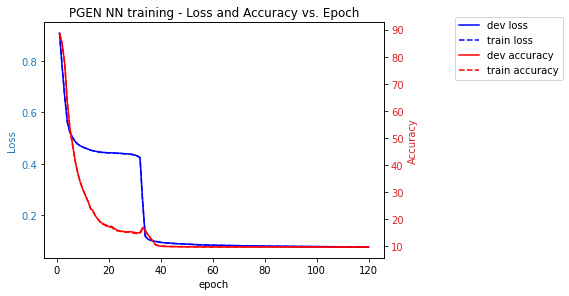

In [9]:
epochs = np.arange(1, args['epochs'] + 1)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss', color = color)
ax1.plot(epochs, dev_losses, 'b-', label = 'dev loss')
ax1.plot(epochs, train_losses, 'b--', label = 'train loss')
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Accuracy', color = color)  # we already handled the x-label with ax1
ax2.plot(epochs, dev_accuracy, 'r-', label='dev accuracy')
ax2.plot(epochs, train_accuracy, 'r--', label='train accuracy')
ax2.tick_params(axis='y', labelcolor = color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PGEN NN training - Loss and Accuracy vs. Epoch')
fig.savefig(FIG_PATH + 'PGEN NN training - Loss and Accuracy vs Epoch', bbox_inches='tight')
plt.show()

# Model Comparison

## Models with different architecture - more/less layers

### Model definition

In [10]:
#model with an extra convolutional layer
#for more documentation refer to the first network
class PGEN_NN_PLS_CONV(nn.Module):
    def __init__(self):
        super(PGEN_NN_PLS_CONV, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = self.conv2(x)  # 32,24,24
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 32,12,12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = self.conv2(x)  # 32,24,24
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

In [11]:
#model without one linear layer
#for more documentation refer to the first network
class PGEN_NN_MNS_LIN(nn.Module):
    def __init__(self):
        super(PGEN_NN_MNS_LIN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2704, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

## Train PGEN_NN_PLS_CONV

In [12]:
#initialize manual seed, this is done again here to receive consistent
#results when running only part of the notebook
torch.manual_seed(args['seed'])
if use_cuda:
    torch.cuda.manual_seed(args['seed'])
    
# create model, initialize optimizer
args['model_name'] = 'pgen_nn_pls_conv'
model2 = PGEN_NN_PLS_CONV().to(device)
optimizer = optim.Adadelta(model2.parameters())

dev_losses_pls_conv, train_losses_pls_conv, dev_accuracy_pls_conv, train_accuracy_pls_conv = main(
    args, model2, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 61.756065
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.121890
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.036266
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.914534
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.938006
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.899864
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.925586
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.942298
Testing train set:

Testing set: Average loss: 0.9632, Accuracy: 43770/50000 (88%), noise average = 783.1429

Testing dev set:

Testing set: Average loss: 0.9625, Accuracy: 8713/10000 (87%), noise average = 783.1429

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.974711
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.976140
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.906530
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.948542
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.952498
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.935323
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.868787
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.9

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.445445
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.449358
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.446883
Testing train set:

Testing set: Average loss: 0.4371, Accuracy: 7095/50000 (14%), noise average = 771.1088

Testing dev set:

Testing set: Average loss: 0.4376, Accuracy: 1450/10000 (14%), noise average = 770.9407

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.449727
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.446725
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.432634
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.436224
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.445967
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.438601
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.440713
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.441644
Testing train set:

Testing set: Average loss: 0.4364, Accuracy: 6902/50000 (14%), noise average = 771.4838

Testing dev set:

Testing set: Average loss: 0.4369, Accuracy: 1417/10000 (14%), noise average = 771.3403

Train Epoch: 


Testing set: Average loss: 0.4211, Accuracy: 6255/50000 (13%), noise average = 765.5989

Testing dev set:

Testing set: Average loss: 0.4224, Accuracy: 1290/10000 (13%), noise average = 765.2859

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.433303
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.426342
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.442837
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.403341
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.263944
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.179170
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.158368
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.152328
Testing train set:

Testing set: Average loss: 0.1242, Accuracy: 3493/50000 (7%), noise average = 768.6865

Testing dev set:

Testing set: Average loss: 0.1238, Accuracy: 704/10000 (7%), noise average = 768.4470

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.132133
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.107874
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.118806
Train Epoch: 29 [19200/50000 (38%)]	Loss:

Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.084449
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.087238
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.088611
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.079636
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.090857
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.090923
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.093557
Testing train set:

Testing set: Average loss: 0.0876, Accuracy: 1280/50000 (3%), noise average = 769.6193

Testing dev set:

Testing set: Average loss: 0.0881, Accuracy: 284/10000 (3%), noise average = 769.3131

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.085696
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.093895
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.094238
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.085891
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.088966
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.091382
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.091477
Train Epoch: 42 [44800/50000 (90%)]	Loss: 0.092307
Testing train set:

Testing s

Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.088749
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.090312
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.091117
Testing train set:

Testing set: Average loss: 0.0836, Accuracy: 1070/50000 (2%), noise average = 769.5514

Testing dev set:

Testing set: Average loss: 0.0841, Accuracy: 241/10000 (2%), noise average = 769.1162

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.078594
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.088535
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.084266
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.095472
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.098185
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.086806
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.084884
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.090283
Testing train set:

Testing set: Average loss: 0.0834, Accuracy: 1098/50000 (2%), noise average = 769.4933

Testing dev set:

Testing set: Average loss: 0.0840, Accuracy: 263/10000 (3%), noise average = 769.0450

Train Epoch: 56 [0/


Testing set: Average loss: 0.0822, Accuracy: 220/10000 (2%), noise average = 768.3667

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.089805
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.085126
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.077402
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.084859
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.078918
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.081385
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.086153
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.081432
Testing train set:

Testing set: Average loss: 0.0814, Accuracy: 898/50000 (2%), noise average = 768.9356

Testing dev set:

Testing set: Average loss: 0.0821, Accuracy: 220/10000 (2%), noise average = 768.4520

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.084110
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.078804
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.079336
Train Epoch: 69 [19200/50000 (38%)]	Loss: 0.082453
Train Epoch: 69 [25600/50000 (51%)]	Loss: 0.088756
Train Epoch: 69 [32000/50000 (64%)]	Loss: 0.08564

Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.079245
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.081256
Train Epoch: 81 [32000/50000 (64%)]	Loss: 0.086775
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.079556
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.079693
Testing train set:

Testing set: Average loss: 0.0793, Accuracy: 852/50000 (2%), noise average = 769.5456

Testing dev set:

Testing set: Average loss: 0.0800, Accuracy: 213/10000 (2%), noise average = 769.0306

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.089757
Train Epoch: 82 [6400/50000 (13%)]	Loss: 0.080427
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.078279
Train Epoch: 82 [19200/50000 (38%)]	Loss: 0.078670
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.085663
Train Epoch: 82 [32000/50000 (64%)]	Loss: 0.075462
Train Epoch: 82 [38400/50000 (77%)]	Loss: 0.084031
Train Epoch: 82 [44800/50000 (90%)]	Loss: 0.088027
Testing train set:

Testing set: Average loss: 0.0792, Accuracy: 836/50000 (2%), noise average = 769.3924

Testing dev set:

Testin

Testing train set:

Testing set: Average loss: 0.0782, Accuracy: 763/50000 (2%), noise average = 769.4442

Testing dev set:

Testing set: Average loss: 0.0790, Accuracy: 190/10000 (2%), noise average = 768.8616

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.087986
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.092361
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.084340
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.099622
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.084172
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.083315
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.086143
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.081583
Testing train set:

Testing set: Average loss: 0.0782, Accuracy: 740/50000 (1%), noise average = 769.3517

Testing dev set:

Testing set: Average loss: 0.0790, Accuracy: 194/10000 (2%), noise average = 768.7702

Train Epoch: 96 [0/50000 (0%)]	Loss: 0.089191
Train Epoch: 96 [6400/50000 (13%)]	Loss: 0.080220
Train Epoch: 96 [12800/50000 (26%)]	Loss: 0.075570
Train Epoch: 96 [19200/5000

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.082076
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.084486
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.078840
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.080841
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.080575
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.081223
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.079125
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.073901
Testing train set:

Testing set: Average loss: 0.0771, Accuracy: 682/50000 (1%), noise average = 769.2086

Testing dev set:

Testing set: Average loss: 0.0779, Accuracy: 183/10000 (2%), noise average = 768.5784

Train Epoch: 109 [0/50000 (0%)]	Loss: 0.087824
Train Epoch: 109 [6400/50000 (13%)]	Loss: 0.090313
Train Epoch: 109 [12800/50000 (26%)]	Loss: 0.075588
Train Epoch: 109 [19200/50000 (38%)]	Loss: 0.077034
Train Epoch: 109 [25600/50000 (51%)]	Loss: 0.079631
Train Epoch: 109 [32000/50000 (64%)]	Loss: 0.083014
Train Epoch: 109 [38400/50000 (77%)]	Loss: 0.086707
Train Epoch: 109 [44

## Train PGEN_NN_MNS_LIN

In [13]:
#initialize manual seed, this is done again here to receive consistent
#results when running only part of the notebook
torch.manual_seed(args['seed'])
if use_cuda:
    torch.cuda.manual_seed(args['seed'])

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_mns_lin'
model3 = PGEN_NN_MNS_LIN().to(device)
optimizer = optim.Adadelta(model3.parameters())

dev_losses_mns_lin, train_losses_mns_lin, dev_accuracy_mns_lin, train_accuracy_mns_lin = main(
    args, model3, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 35.581367
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.094391
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.957715
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.792555
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.893005
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.802688
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.795335
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.741279
Testing train set:

Testing set: Average loss: 0.7467, Accuracy: 42615/50000 (85%), noise average = 760.6472

Testing dev set:

Testing set: Average loss: 0.7454, Accuracy: 8508/10000 (85%), noise average = 760.5284

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.732157
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.760563
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.690707
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.737879
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.707350
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.713324
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.678844
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.7

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.521039
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.543847
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.548397
Testing train set:

Testing set: Average loss: 0.5325, Accuracy: 29435/50000 (59%), noise average = 749.3168

Testing dev set:

Testing set: Average loss: 0.5333, Accuracy: 5913/10000 (59%), noise average = 749.1291

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.550225
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.540541
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.532185
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.531321
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.538768
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.543294
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.530443
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.546041
Testing train set:

Testing set: Average loss: 0.5205, Accuracy: 27903/50000 (56%), noise average = 749.2563

Testing dev set:

Testing set: Average loss: 0.5216, Accuracy: 5660/10000 (57%), noise average = 749.0872

Train Epoch

Testing train set:

Testing set: Average loss: 0.4936, Accuracy: 22824/50000 (46%), noise average = 744.5338

Testing dev set:

Testing set: Average loss: 0.4950, Accuracy: 4653/10000 (47%), noise average = 744.2965

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.499049
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.480504
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.510142
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.492655
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.476679
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.490284
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.500325
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.491663
Testing train set:

Testing set: Average loss: 0.4907, Accuracy: 22139/50000 (44%), noise average = 744.7025

Testing dev set:

Testing set: Average loss: 0.4919, Accuracy: 4527/10000 (45%), noise average = 744.4406

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.486782
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.505870
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.486912
Train Epoch: 29 [

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.482024
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.468104
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.471551
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.475041
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.470608
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.474525
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.478702
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.470910
Testing train set:

Testing set: Average loss: 0.4734, Accuracy: 17248/50000 (34%), noise average = 742.9406

Testing dev set:

Testing set: Average loss: 0.4745, Accuracy: 3581/10000 (36%), noise average = 742.6696

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.468459
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.479433
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.480195
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.476053
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.462740
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.490643
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.477351
Train Epoch: 42 [44800/50000 (

Train Epoch: 54 [19200/50000 (38%)]	Loss: 0.463653
Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.454095
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.466910
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.472474
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.467772
Testing train set:

Testing set: Average loss: 0.4669, Accuracy: 15356/50000 (31%), noise average = 739.8434

Testing dev set:

Testing set: Average loss: 0.4680, Accuracy: 3193/10000 (32%), noise average = 739.5347

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.464404
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.471653
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.470972
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.473882
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.466192
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.468714
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.465432
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.462692
Testing train set:

Testing set: Average loss: 0.4661, Accuracy: 15194/50000 (30%), noise average = 738.8495

Testing dev set:

Train Epoch: 67 [38400/50000 (77%)]	Loss: 0.461447
Train Epoch: 67 [44800/50000 (90%)]	Loss: 0.455420
Testing train set:

Testing set: Average loss: 0.4603, Accuracy: 13580/50000 (27%), noise average = 738.1358

Testing dev set:

Testing set: Average loss: 0.4615, Accuracy: 2817/10000 (28%), noise average = 737.8015

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.463648
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.461262
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.468313
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.459122
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.464691
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.459281
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.463843
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.463663
Testing train set:

Testing set: Average loss: 0.4600, Accuracy: 13496/50000 (27%), noise average = 738.5397

Testing dev set:

Testing set: Average loss: 0.4611, Accuracy: 2808/10000 (28%), noise average = 738.2213

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.472001
Train Epoch: 69 


Testing set: Average loss: 0.4555, Accuracy: 2453/10000 (25%), noise average = 738.0543

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.451817
Train Epoch: 81 [6400/50000 (13%)]	Loss: 0.459614
Train Epoch: 81 [12800/50000 (26%)]	Loss: 0.448234
Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.448468
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.459360
Train Epoch: 81 [32000/50000 (64%)]	Loss: 0.457844
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.457091
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.457501
Testing train set:

Testing set: Average loss: 0.4537, Accuracy: 11551/50000 (23%), noise average = 737.9156

Testing dev set:

Testing set: Average loss: 0.4548, Accuracy: 2406/10000 (24%), noise average = 737.5805

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.454178
Train Epoch: 82 [6400/50000 (13%)]	Loss: 0.452211
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.451664
Train Epoch: 82 [19200/50000 (38%)]	Loss: 0.457649
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.449808
Train Epoch: 82 [32000/50000 (64%)]	Loss: 

Train Epoch: 94 [12800/50000 (26%)]	Loss: 0.458155
Train Epoch: 94 [19200/50000 (38%)]	Loss: 0.448374
Train Epoch: 94 [25600/50000 (51%)]	Loss: 0.450707
Train Epoch: 94 [32000/50000 (64%)]	Loss: 0.441190
Train Epoch: 94 [38400/50000 (77%)]	Loss: 0.455731
Train Epoch: 94 [44800/50000 (90%)]	Loss: 0.453639
Testing train set:

Testing set: Average loss: 0.4502, Accuracy: 10387/50000 (21%), noise average = 737.2510

Testing dev set:

Testing set: Average loss: 0.4513, Accuracy: 2178/10000 (22%), noise average = 736.8375

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.445846
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.450108
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.448433
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.454613
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.446600
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.450076
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.450422
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.446192
Testing train set:

Testing set: Average loss: 0.4501, Accuracy: 10333/5000

Train Epoch: 107 [25600/50000 (51%)]	Loss: 0.460652
Train Epoch: 107 [32000/50000 (64%)]	Loss: 0.449196
Train Epoch: 107 [38400/50000 (77%)]	Loss: 0.442340
Train Epoch: 107 [44800/50000 (90%)]	Loss: 0.457496
Testing train set:

Testing set: Average loss: 0.4477, Accuracy: 9721/50000 (19%), noise average = 735.8273

Testing dev set:

Testing set: Average loss: 0.4487, Accuracy: 2056/10000 (21%), noise average = 735.3822

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.444925
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.450883
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.443653
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.450912
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.458422
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.454020
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.442813
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.444688
Testing train set:

Testing set: Average loss: 0.4473, Accuracy: 9575/50000 (19%), noise average = 735.0117

Testing dev set:

Testing set: Average loss: 0.4484, Accu

Train Epoch: 120 [38400/50000 (77%)]	Loss: 0.452237
Train Epoch: 120 [44800/50000 (90%)]	Loss: 0.445427
Testing train set:

Testing set: Average loss: 0.4463, Accuracy: 9327/50000 (19%), noise average = 734.2162

Testing dev set:

Testing set: Average loss: 0.4473, Accuracy: 1947/10000 (19%), noise average = 733.7325

Training took 1084.170 seconds
Best model was achieved on epoch 120


## Plot comperative graphs

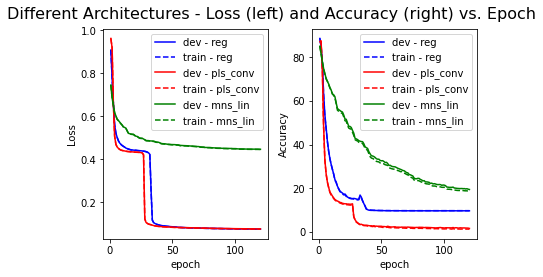

In [14]:
epochs = np.arange(1, args['epochs'] + 1)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss')
ax1.plot(epochs, dev_losses, 'b-', label = 'dev - reg')
ax1.plot(epochs, train_losses, 'b--', label = 'train - reg')
ax1.plot(epochs, dev_losses_pls_conv, 'r-', label = 'dev - pls_conv')
ax1.plot(epochs, train_losses_pls_conv, 'r--', label = 'train - pls_conv')
ax1.plot(epochs, dev_losses_mns_lin, 'g-', label = 'dev - mns_lin')
ax1.plot(epochs, train_losses_mns_lin, 'g--', label = 'train - mns_lin')
ax1.tick_params(axis='y')

ax2.set_xlabel('epoch')
ax2.set_ylabel('Accuracy') 
ax2.plot(epochs, dev_accuracy, 'b-', label = 'dev - reg')
ax2.plot(epochs, train_accuracy, 'b--', label = 'train - reg')
ax2.plot(epochs, dev_accuracy_pls_conv, 'r-', label = 'dev - pls_conv')
ax2.plot(epochs, train_accuracy_pls_conv, 'r--', label = 'train - pls_conv')
ax2.plot(epochs, dev_accuracy_mns_lin, 'g-', label = 'dev - mns_lin')
ax2.plot(epochs, train_accuracy_mns_lin, 'g--', label = 'train - mns_lin')
ax2.tick_params(axis='y')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
fig.suptitle('Different Architectures - Loss (left) and Accuracy (right) vs. Epoch', fontsize=16)
fig.savefig(FIG_PATH + 'Different Architectures - Loss and Accuracy vs Epoch', bbox_inches='tight')
plt.show()

In [15]:
print('Testing test set:')
_ = test(model2, device, test_loader, cnn)

Testing test set:

Testing set: Average loss: 0.0782, Accuracy: 127/10000 (1%), noise average = 768.4848



# # Models with different architecture - changing sizes

In [16]:
c = 16
h = 2048

args['epochs'] = 60
#initialize manual seed, this is done again here to receive consistent
#results when running only part of the notebook
torch.manual_seed(args['seed'])
if use_cuda:
    torch.cuda.manual_seed(args['seed'])

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_c16_h2048'
model4 = PGEN_NN(c=c, h=h).to(device)
optimizer = optim.Adadelta(model4.parameters())

dev_losses_c16_h2048, train_losses_c16_h2048, dev_accuracy_c16_h2048, train_accuracy_c16_h2048 = main(
    args, model4, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 59.524902
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.090941
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.186616
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.123927
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.134740
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.079867
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.291690
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.330199
Testing train set:

Testing set: Average loss: 1.1048, Accuracy: 46088/50000 (92%), noise average = 783.2709

Testing dev set:

Testing set: Average loss: 1.1062, Accuracy: 9241/10000 (92%), noise average = 783.2670

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.086099
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.142071
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.959602
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.063993
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.991146
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.962583
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.235827
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.9

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.498647
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.487213
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.486436
Testing train set:

Testing set: Average loss: 0.4763, Accuracy: 19036/50000 (38%), noise average = 760.0089

Testing dev set:

Testing set: Average loss: 0.4768, Accuracy: 3818/10000 (38%), noise average = 759.8015

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.476192
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.489475
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.483143
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.494347
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.477401
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.484272
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.492733
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.475038
Testing train set:

Testing set: Average loss: 0.4741, Accuracy: 18378/50000 (37%), noise average = 760.0348

Testing dev set:

Testing set: Average loss: 0.4746, Accuracy: 3720/10000 (37%), noise average = 759.8436

Train Epoch

Testing train set:

Testing set: Average loss: 0.4520, Accuracy: 11895/50000 (24%), noise average = 757.2539

Testing dev set:

Testing set: Average loss: 0.4528, Accuracy: 2442/10000 (24%), noise average = 756.9696

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.454687
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.451952
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.448630
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.459382
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.451418
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.453664
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.457004
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.456588
Testing train set:

Testing set: Average loss: 0.4512, Accuracy: 11537/50000 (23%), noise average = 756.6110

Testing dev set:

Testing set: Average loss: 0.4520, Accuracy: 2396/10000 (24%), noise average = 756.3551

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.453087
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.453647
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.458798
Train Epoch: 29 [

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.447705
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.449041
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.450019
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.442726
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.447272
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.438485
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.448899
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.454376
Testing train set:

Testing set: Average loss: 0.4452, Accuracy: 9635/50000 (19%), noise average = 755.5498

Testing dev set:

Testing set: Average loss: 0.4460, Accuracy: 1981/10000 (20%), noise average = 755.2460

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.459557
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.442514
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.452305
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.447731
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.438138
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.448080
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.445500
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.446445
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.450443
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.447688
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.454514
Testing train set:

Testing set: Average loss: 0.4410, Accuracy: 8405/50000 (17%), noise average = 751.7218

Testing dev set:

Testing set: Average loss: 0.4419, Accuracy: 1743/10000 (17%), noise average = 751.3571

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.440490
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.443355
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.439620
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.438720
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.437420
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.443237
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.446790
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.437705
Testing train set:

Testing set: Average loss: 0.4407, Accuracy: 8349/50000 (17%), noise average = 751.4800

Testing dev set:

Testing set: Average loss: 0.4417, Accuracy: 1733/1

In [17]:
c = 8
h = 1024

#initialize manual seed, this is done again here to receive consistent
#results when running only part of the notebook
torch.manual_seed(args['seed'])
if use_cuda:
    torch.cuda.manual_seed(args['seed'])

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_c8_h1024'
model5 = PGEN_NN(c=c, h=h).to(device)
optimizer = optim.Adadelta(model5.parameters())

dev_losses_c8_h1024, train_losses_c8_h1024, dev_accuracy_c8_h1024, train_accuracy_c8_h1024 = main(
    args, model5, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 78.852531
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.042969
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.071395
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.976009
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.006663
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.839494
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.045353
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.941406
Testing train set:

Testing set: Average loss: 0.9256, Accuracy: 43016/50000 (86%), noise average = 778.2539

Testing dev set:

Testing set: Average loss: 0.9252, Accuracy: 8605/10000 (86%), noise average = 778.2002

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.909555
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.851699
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.882080
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.738232
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.914922
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.858417
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.864818
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.8

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.485464
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.459011
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.455590
Testing train set:

Testing set: Average loss: 0.4514, Accuracy: 12330/50000 (25%), noise average = 762.0134

Testing dev set:

Testing set: Average loss: 0.4518, Accuracy: 2471/10000 (25%), noise average = 761.7736

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.460125
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.455372
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.475149
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.464901
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.459725
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.445187
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.452372
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.457937
Testing train set:

Testing set: Average loss: 0.4496, Accuracy: 11577/50000 (23%), noise average = 762.5859

Testing dev set:

Testing set: Average loss: 0.4501, Accuracy: 2335/10000 (23%), noise average = 762.4105

Train Epoch


Testing set: Average loss: 0.4402, Accuracy: 8186/50000 (16%), noise average = 758.4964

Testing dev set:

Testing set: Average loss: 0.4407, Accuracy: 1670/10000 (17%), noise average = 758.2603

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.446925
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.447928
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.444529
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.442606
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.442921
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.444338
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.446529
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.439798
Testing train set:

Testing set: Average loss: 0.4398, Accuracy: 8112/50000 (16%), noise average = 758.2460

Testing dev set:

Testing set: Average loss: 0.4403, Accuracy: 1667/10000 (17%), noise average = 758.0331

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.446191
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.448856
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.449034
Train Epoch: 29 [19200/50000 (38%)]	Lo

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.438344
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.449791
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.434560
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.435967
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.439129
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.439298
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.437774
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.435356
Testing train set:

Testing set: Average loss: 0.4348, Accuracy: 6617/50000 (13%), noise average = 753.0268

Testing dev set:

Testing set: Average loss: 0.4354, Accuracy: 1344/10000 (13%), noise average = 752.7454

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.438486
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.437592
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.441186
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.445104
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.437311
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.439065
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.432783
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.434442
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.434076
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.427939
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.437130
Testing train set:

Testing set: Average loss: 0.4255, Accuracy: 5400/50000 (11%), noise average = 745.7311

Testing dev set:

Testing set: Average loss: 0.4266, Accuracy: 1094/10000 (11%), noise average = 745.2966

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.433662
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.433954
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.432036
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.422953
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.421728
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.417598
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.409860
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.417946
Testing train set:

Testing set: Average loss: 0.3997, Accuracy: 5855/50000 (12%), noise average = 734.7122

Testing dev set:

Testing set: Average loss: 0.4012, Accuracy: 1206/1

In [18]:
c = 8
h = 2048

#initialize manual seed, this is done again here to receive consistent
#results when running only part of the notebook
torch.manual_seed(args['seed'])
if use_cuda:
    torch.cuda.manual_seed(args['seed'])

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_c8_h2048'
model6 = PGEN_NN(c=c, h=h).to(device)
optimizer = optim.Adadelta(model6.parameters())

dev_losses_c8_h2048, train_losses_c8_h2048, dev_accuracy_c8_h2048, train_accuracy_c8_h2048 = main(
    args, model6, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 245.298874
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.994781
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.977628
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.984783
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.956125
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.985899
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.878966
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.969684
Testing train set:

Testing set: Average loss: 0.9309, Accuracy: 44726/50000 (89%), noise average = 781.5037

Testing dev set:

Testing set: Average loss: 0.9259, Accuracy: 8924/10000 (89%), noise average = 781.4941

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.825951
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.948041
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.822871
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.002641
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.949088
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.877702
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.908858
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.481419
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.469248
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.478882
Testing train set:

Testing set: Average loss: 0.4711, Accuracy: 17272/50000 (35%), noise average = 761.7336

Testing dev set:

Testing set: Average loss: 0.4715, Accuracy: 3483/10000 (35%), noise average = 761.5522

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.471629
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.486520
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.475754
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.488556
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.472445
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.486491
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.475553
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.468883
Testing train set:

Testing set: Average loss: 0.4669, Accuracy: 16175/50000 (32%), noise average = 761.3946

Testing dev set:

Testing set: Average loss: 0.4673, Accuracy: 3243/10000 (32%), noise average = 761.2458

Train Epoch

Testing train set:

Testing set: Average loss: 0.4489, Accuracy: 10488/50000 (21%), noise average = 757.7296

Testing dev set:

Testing set: Average loss: 0.4494, Accuracy: 2092/10000 (21%), noise average = 757.5443

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.460763
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.458644
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.446194
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.457660
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.456417
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.451623
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.453124
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.452930
Testing train set:

Testing set: Average loss: 0.4482, Accuracy: 10197/50000 (20%), noise average = 757.4601

Testing dev set:

Testing set: Average loss: 0.4487, Accuracy: 2037/10000 (20%), noise average = 757.2639

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.454233
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.457361
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.451953
Train Epoch: 29 [

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.446258
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.444131
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.446076
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.446938
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.443517
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.447452
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.442719
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.454894
Testing train set:

Testing set: Average loss: 0.4418, Accuracy: 8212/50000 (16%), noise average = 754.9856

Testing dev set:

Testing set: Average loss: 0.4425, Accuracy: 1676/10000 (17%), noise average = 754.7329

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.447007
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.445226
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.441754
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.444199
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.446131
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.450051
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.455183
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.437047
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.440806
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.445919
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.439441
Testing train set:

Testing set: Average loss: 0.4388, Accuracy: 7485/50000 (15%), noise average = 752.9039

Testing dev set:

Testing set: Average loss: 0.4395, Accuracy: 1561/10000 (16%), noise average = 752.6494

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.442825
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.438497
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.441159
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.445443
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.446818
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.439579
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.443373
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.444888
Testing train set:

Testing set: Average loss: 0.4385, Accuracy: 7413/50000 (15%), noise average = 752.0750

Testing dev set:

Testing set: Average loss: 0.4392, Accuracy: 1533/1

In [19]:
c = 32
h = 2048

#initialize manual seed, this is done again here to receive consistent
#results when running only part of the notebook
torch.manual_seed(args['seed'])
if use_cuda:
    torch.cuda.manual_seed(args['seed'])

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_c32_h2048'
model7 = PGEN_NN(c=c, h=h).to(device)
optimizer = optim.Adadelta(model7.parameters())

dev_losses_c32_h2048, train_losses_c32_h2048, dev_accuracy_c32_h2048, train_accuracy_c32_h2048 = main(
    args, model7, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 11.007808
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.425836
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.467269
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.373921
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.288094
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.349487
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.249085
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.288136
Testing train set:

Testing set: Average loss: 0.3218, Accuracy: 22609/50000 (45%), noise average = 769.3224

Testing dev set:

Testing set: Average loss: 0.3236, Accuracy: 4522/10000 (45%), noise average = 769.2466

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.304374
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.249011
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.337295
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.357462
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.342239
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.252235
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.334556
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.3

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.143907
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.183093
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.144032
Testing train set:

Testing set: Average loss: 0.1617, Accuracy: 12859/50000 (26%), noise average = 751.1572

Testing dev set:

Testing set: Average loss: 0.1624, Accuracy: 2565/10000 (26%), noise average = 751.0935

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.158766
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.165306
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.165157
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.143075
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.162926
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.151243
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.188402
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.160414
Testing train set:

Testing set: Average loss: 0.1606, Accuracy: 12697/50000 (25%), noise average = 749.6174

Testing dev set:

Testing set: Average loss: 0.1602, Accuracy: 2547/10000 (25%), noise average = 749.5370

Train Epoch

Testing train set:

Testing set: Average loss: 0.1291, Accuracy: 9131/50000 (18%), noise average = 748.6805

Testing dev set:

Testing set: Average loss: 0.1296, Accuracy: 1848/10000 (18%), noise average = 748.4998

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.117613
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.132935
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.138378
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.148507
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.133462
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.145812
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.127714
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.120698
Testing train set:

Testing set: Average loss: 0.1274, Accuracy: 9010/50000 (18%), noise average = 748.7897

Testing dev set:

Testing set: Average loss: 0.1277, Accuracy: 1820/10000 (18%), noise average = 748.6541

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.125801
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.141809
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.148922
Train Epoch: 29 [19

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.110938
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.128453
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.110809
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.136083
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.131639
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.101621
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.107105
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.113362
Testing train set:

Testing set: Average loss: 0.1099, Accuracy: 6985/50000 (14%), noise average = 748.6445

Testing dev set:

Testing set: Average loss: 0.1104, Accuracy: 1406/10000 (14%), noise average = 748.4413

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.126444
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.137472
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.111176
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.109366
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.105191
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.101095
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.112010
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.092246
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.087402
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.101656
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.105668
Testing train set:

Testing set: Average loss: 0.1043, Accuracy: 6266/50000 (13%), noise average = 748.7053

Testing dev set:

Testing set: Average loss: 0.1048, Accuracy: 1256/10000 (13%), noise average = 748.4665

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.102380
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.105026
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.109871
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.093640
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.102501
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.115493
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.106311
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.097489
Testing train set:

Testing set: Average loss: 0.1041, Accuracy: 6239/50000 (12%), noise average = 748.5778

Testing dev set:

Testing set: Average loss: 0.1046, Accuracy: 1248/1

In [20]:
c = 32
h = 1024

#initialize manual seed, this is done again here to receive consistent
#results when running only part of the notebook
torch.manual_seed(args['seed'])
if use_cuda:
    torch.cuda.manual_seed(args['seed'])

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_c32_h1024'
model8 = PGEN_NN(c=c, h=h).to(device)
optimizer = optim.Adadelta(model8.parameters())

dev_losses_c32_h1024, train_losses_c32_h1024, dev_accuracy_c32_h1024, train_accuracy_c32_h1024 = main(
    args, model8, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 252.485474
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.786215
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.821567
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.797265
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.784666
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.742177
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.794298
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.788438
Testing train set:

Testing set: Average loss: 0.7522, Accuracy: 42559/50000 (85%), noise average = 778.2906

Testing dev set:

Testing set: Average loss: 0.7532, Accuracy: 8526/10000 (85%), noise average = 778.2466

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.753981
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.793749
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.745030
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.742855
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.696588
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.758328
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.662869
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.455580
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.458414
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.462524
Testing train set:

Testing set: Average loss: 0.4561, Accuracy: 12966/50000 (26%), noise average = 765.5717

Testing dev set:

Testing set: Average loss: 0.4567, Accuracy: 2654/10000 (27%), noise average = 765.4924

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.454997
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.459646
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.464440
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.455530
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.461600
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.474648
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.462397
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.460923
Testing train set:

Testing set: Average loss: 0.4549, Accuracy: 12740/50000 (25%), noise average = 764.8712

Testing dev set:

Testing set: Average loss: 0.4556, Accuracy: 2567/10000 (26%), noise average = 764.7801

Train Epoch

Testing train set:

Testing set: Average loss: 0.4421, Accuracy: 8734/50000 (17%), noise average = 761.6672

Testing dev set:

Testing set: Average loss: 0.4426, Accuracy: 1750/10000 (18%), noise average = 761.5335

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.443690
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.444034
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.453846
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.450977
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.443833
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.448903
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.441094
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.443707
Testing train set:

Testing set: Average loss: 0.4418, Accuracy: 8613/50000 (17%), noise average = 761.2068

Testing dev set:

Testing set: Average loss: 0.4424, Accuracy: 1753/10000 (18%), noise average = 761.0440

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.441563
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.447712
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.443403
Train Epoch: 29 [19

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.439234
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.438509
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.439456
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.441282
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.448964
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.447358
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.443740
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.439007
Testing train set:

Testing set: Average loss: 0.4378, Accuracy: 7470/50000 (15%), noise average = 758.7183

Testing dev set:

Testing set: Average loss: 0.4384, Accuracy: 1518/10000 (15%), noise average = 758.5482

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.439645
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.447289
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.443108
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.442116
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.438277
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.444232
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.440682
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.439745
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.438142
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.440732
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.437419
Testing train set:

Testing set: Average loss: 0.4347, Accuracy: 6850/50000 (14%), noise average = 755.8489

Testing dev set:

Testing set: Average loss: 0.4355, Accuracy: 1414/10000 (14%), noise average = 755.6737

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.435003
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.444446
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.439636
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.437946
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.441001
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.439301
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.439578
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.438643
Testing train set:

Testing set: Average loss: 0.4343, Accuracy: 6812/50000 (14%), noise average = 756.1747

Testing dev set:

Testing set: Average loss: 0.4351, Accuracy: 1409/1

## Plot comperative graphs

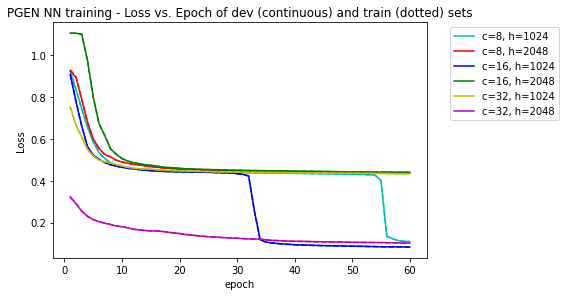

In [27]:
n_epochs = args['epochs']
epochs = np.arange(1, n_epochs + 1)
dev_losses, train_losses, dev_accuracy, train_accuracy = dev_losses[:n_epochs],\
    train_losses[:n_epochs], dev_accuracy[:n_epochs], train_accuracy[:n_epochs]

plt.xlabel('epoch')
plt.ylabel('Loss')

plt.plot(epochs, dev_losses_c8_h1024, '-c', label = 'c=8, h=1024')
plt.plot(epochs, train_losses_c8_h1024, '--c')
plt.plot(epochs, dev_losses_c8_h2048, '-r', label = 'c=8, h=2048')
plt.plot(epochs, train_losses_c8_h2048, '--r')
plt.plot(epochs, dev_losses, '-b', label = 'c=16, h=1024')
plt.plot(epochs, train_losses, '--b')
plt.plot(epochs, dev_losses_c16_h2048, '-g', label = 'c=16, h=2048')
plt.plot(epochs, train_losses_c16_h2048, '--g')
plt.plot(epochs, dev_losses_c32_h1024, '-y', label = 'c=32, h=1024')
plt.plot(epochs, train_losses_c32_h1024, '--y')
plt.plot(epochs, dev_losses_c32_h2048, '-m', label = 'c=32, h=2048')
plt.plot(epochs, train_losses_c32_h2048, '--m')



plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PGEN NN training - Loss vs. Epoch of dev (continuous) and train (dotted) sets')
plt.savefig(FIG_PATH + 'PGEN NN training - Loss vs Epoch of dev (continuous) and train (dotted) sets', bbox_inches='tight')
plt.show()

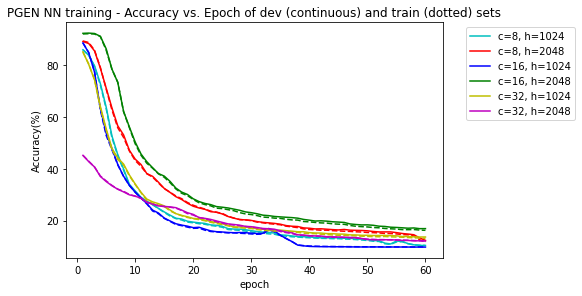

In [29]:
plt.xlabel('epoch')
plt.ylabel('Accuracy(%)')

plt.plot(epochs, dev_accuracy_c8_h1024, '-c', label = 'c=8, h=1024')
plt.plot(epochs, train_accuracy_c8_h1024, '--c')
plt.plot(epochs, dev_accuracy_c8_h2048, '-r', label = 'c=8, h=2048')
plt.plot(epochs, train_accuracy_c8_h2048, '--r')
plt.plot(epochs, dev_accuracy, '-b', label = 'c=16, h=1024')
plt.plot(epochs, train_accuracy, '--b')
plt.plot(epochs, dev_accuracy_c16_h2048, '-g', label = 'c=16, h=2048')
plt.plot(epochs, train_accuracy_c16_h2048, '--g')
plt.plot(epochs, dev_accuracy_c32_h1024, '-y', label = 'c=32, h=1024')
plt.plot(epochs, train_accuracy_c32_h1024, '--y')
plt.plot(epochs, dev_accuracy_c32_h2048, '-m', label = 'c=32, h=2048')
plt.plot(epochs, train_accuracy_c32_h2048, '--m')



plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PGEN NN training - Accuracy vs. Epoch of dev (continuous) and train (dotted) sets')
plt.savefig(FIG_PATH + 'PGEN NN training - Accuracy vs Epoch of dev (continuous) and train (dotted) sets', bbox_inches='tight')
plt.show()

# AIC and BIC comparisons

In [168]:
def likelihood_comp(data_loader, model, device, cnn):
    """
    input:
    data_loader - a data loader for the data on which likelihood is wanted to be computed
    model - neural network creating AE
    device - cpu or cuda
    cnn - a classifying convolutional neural network
    
    output:
    log_likelihood - the log-likelihood of the data on the models
    """
    model.eval()
    log_likelihood = 0
    num_exm = len(data_loader.dataset)
    delta = 1e-20 #for computationla stability
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output, noise = model.generate(data, device) #create AE
            preds = cnn(output) #check AE
            
            output = 1 - torch.exp(preds) + delta #calculate 1 - probability for each option
            mask = torch.zeros(len(target), 10).to(device)
            mask.scatter_(1, target.unsqueeze(1), 1.)
            output = torch.sum(output * mask, dim = 1) #look only at the probability of the target
            log_likelihood += torch.sum(torch.log(output)) #sum log likelihoods 

    return log_likelihood.item()

def number_of_params(model):
    """
    input:
    model - a neural network to count its parameters
    
    output:
    count - number of parameters (int)
    """
    params = model.parameters()
    count = 0
    for param in params:
        num_params = list(torch.reshape(param, (-1,)).size())[0]
        count += num_params
    return count

def calculate_BIC(likelihood, model, sample_size):
    """
    Calculate the Bayesian Information Criterion (BIC) for a GPy `model` with maximum likelihood hyperparameters on a given dataset
    https://enwikipediaorg/wiki/Bayesian_information_criterion
    """
    # likelihood is the natural logarithm of the marginal likelihood
    # sample_size is the number of data points
    # number_of_params() is the number of optimisation parameters
    return - 2 * likelihood + np.log(sample_size) * number_of_params(model)

def calculate_AIC(likelihood, model):
    # likelihood is the natural logarithm of the marginal likelihood
    # sample_size is the number of data points
    return - 2 * likelihood + 2 * number_of_params(model)

In [169]:
model1_num_params = number_of_params(model1)
model2_num_params = number_of_params(model2)
model3_num_params = number_of_params(model3)
model4_num_params = number_of_params(model4)
model5_num_params = number_of_params(model5)
model6_num_params = number_of_params(model6)
model7_num_params = number_of_params(model7)
model8_num_params = number_of_params(model8)

table = [["c=8, h=1024", model5_num_params], ["c=8, h=2048", model6_num_params], ["c=16, h=1024", model1_num_params],
            ["c=16, h=2048", model4_num_params], ["c=32, h=1024", model8_num_params], ["c=32, h=2048", model7_num_params],
            ["PLS_CONV", model2_num_params], ["MNS_LIN", model3_num_params]]

print(tabulate(table, headers=["model", "number of parameters"]))

model           number of parameters
------------  ----------------------
c=8, h=1024                  2189152
c=8, h=2048                  4377440
c=16, h=1024                 3573680
c=16, h=2048                 7146416
c=32, h=1024                 6342736
c=32, h=2048                12684368
PLS_CONV                     5528016
MNS_LIN                      2120880


In [55]:
dev_sample_size = len(dev_loader.dataset)

model1_dev_likelihood = likelihood_comp(dev_loader, model1, device, cnn)
model2_dev_likelihood = likelihood_comp(dev_loader, model2, device, cnn)
model3_dev_likelihood = likelihood_comp(dev_loader, model3, device, cnn)

model1_dev_aic = calculate_AIC(model1_dev_likelihood, model1)
model2_dev_aic = calculate_AIC(model2_dev_likelihood, model2)
model3_dev_aic = calculate_AIC(model3_dev_likelihood, model3)

model1_dev_bic = calculate_BIC(model1_dev_likelihood, model1, dev_sample_size)
model2_dev_bic = calculate_BIC(model2_dev_likelihood, model2, dev_sample_size)
model3_dev_bic = calculate_BIC(model3_dev_likelihood, model3, dev_sample_size)

table = [["AIC", model1_dev_aic, model2_dev_aic, model3_dev_aic],
        ["BIC", model1_dev_bic, model2_dev_bic, model3_dev_bic]]
print("dev set comparison:")
print(tabulate(table, headers=["Regular model", "PLS_CONV", "MNS_LIN"]))

tensor(-43797.8516, device='cuda:0')
tensor(-1325.7885, device='cuda:0')
tensor(-1150.5764, device='cuda:0')
dev set comparison:
       Regular model     PLS_CONV      MNS_LIN
---  ---------------  -----------  -----------
AIC      7.23496e+06  1.10587e+07  4.24406e+06
BIC      3.30024e+07  5.09176e+07  1.95363e+07


In [56]:
train_sample_size = len(train_loader.dataset)

model1_train_likelihood = likelihood_comp(train_loader, model1, device, cnn)
model2_train_likelihood = likelihood_comp(train_loader, model2, device, cnn)
model3_train_likelihood = likelihood_comp(train_loader, model3, device, cnn)

model1_train_aic = calculate_AIC(model1_train_likelihood, model1)
model2_train_aic = calculate_AIC(model2_train_likelihood, model2)
model3_train_aic = calculate_AIC(model3_train_likelihood, model3)

model1_train_bic = calculate_BIC(model1_train_likelihood, model1, train_sample_size)
model2_train_bic = calculate_BIC(model2_train_likelihood, model2, train_sample_size)
model3_train_bic = calculate_BIC(model3_train_likelihood, model3, train_sample_size)

table = [["AIC", model1_train_aic, model2_train_aic, model3_train_aic],
        ["BIC", model1_train_bic, model2_train_bic, model3_train_bic]]
print("train set comparison:")
print(tabulate(table, headers=["Regular model", "PLS_CONV", "MNS_LIN"]))

tensor(-220036.1562, device='cuda:0')
tensor(-5271.7866, device='cuda:0')
tensor(-5721.2822, device='cuda:0')
train set comparison:
       Regular model     PLS_CONV      MNS_LIN
---  ---------------  -----------  -----------
AIC      7.58743e+06  1.10666e+07  4.2532e+06
BIC      3.91065e+07  5.98225e+07  2.29589e+07


In [57]:
dev_sample_size = len(dev_loader.dataset)

model1_dev_likelihood = likelihood_comp(dev_loader, model1, device, cnn)
model4_dev_likelihood = likelihood_comp(dev_loader, model4, device, cnn)
model5_dev_likelihood = likelihood_comp(dev_loader, model5, device, cnn)
model6_dev_likelihood = likelihood_comp(dev_loader, model6, device, cnn)
model7_dev_likelihood = likelihood_comp(dev_loader, model7, device, cnn)
model8_dev_likelihood = likelihood_comp(dev_loader, model8, device, cnn)


model1_dev_aic = calculate_AIC(model1_dev_likelihood, model1)
model4_dev_aic = calculate_AIC(model2_dev_likelihood, model4)
model5_dev_aic = calculate_AIC(model3_dev_likelihood, model5)
model6_dev_aic = calculate_AIC(model1_dev_likelihood, model6)
model7_dev_aic = calculate_AIC(model2_dev_likelihood, model7)
model8_dev_aic = calculate_AIC(model3_dev_likelihood, model8)

model1_dev_bic = calculate_BIC(model1_dev_likelihood, model1, dev_sample_size)
model4_dev_bic = calculate_BIC(model2_dev_likelihood, model4, dev_sample_size)
model5_dev_bic = calculate_BIC(model3_dev_likelihood, model5, dev_sample_size)
model6_dev_bic = calculate_BIC(model1_dev_likelihood, model6, dev_sample_size)
model7_dev_bic = calculate_BIC(model2_dev_likelihood, model7, dev_sample_size)
model8_dev_bic = calculate_BIC(model3_dev_likelihood, model8, dev_sample_size)

table = [["AIC", model5_dev_aic, model6_dev_aic, model1_dev_aic, model4_dev_aic, model8_dev_aic, model7_dev_aic],
        ["BIC", model5_dev_bic, model6_dev_bic, model1_dev_bic, model4_dev_bic, model8_dev_bic, model7_dev_bic]]
print("dev set comparison:")
print(tabulate(table, headers=["c=8, h=1024", "c=8, h=2048", "c=16, h=1024", "c=16, h=2048", "c=32, h=1024", "c=32, h=2048"]))

tensor(-43797.8477, device='cuda:0')
tensor(-1108.1836, device='cuda:0')
tensor(-37666.1016, device='cuda:0')
tensor(-1080.4438, device='cuda:0')
tensor(-44266.7344, device='cuda:0')
tensor(-1064.7834, device='cuda:0')
dev set comparison:
       c=8, h=1024    c=8, h=2048    c=16, h=1024    c=16, h=2048    c=32, h=1024    c=32, h=2048
---  -------------  -------------  --------------  --------------  --------------  --------------
AIC    4.38061e+06    8.84248e+06     7.23496e+06     1.42955e+07     1.26878e+07     2.53714e+07
BIC    2.01651e+07    4.04053e+07     3.30024e+07     6.58236e+07     5.84211e+07     1.1683e+08


In [59]:
train_sample_size = len(train_loader.dataset)

model1_train_likelihood = likelihood_comp(train_loader, model1, device, cnn)
model4_train_likelihood = likelihood_comp(train_loader, model4, device, cnn)
model5_train_likelihood = likelihood_comp(train_loader, model5, device, cnn)
model6_train_likelihood = likelihood_comp(train_loader, model6, device, cnn)
model7_train_likelihood = likelihood_comp(train_loader, model7, device, cnn)
model8_train_likelihood = likelihood_comp(train_loader, model8, device, cnn)


model1_train_aic = calculate_AIC(model1_train_likelihood, model1)
model4_train_aic = calculate_AIC(model2_train_likelihood, model4)
model5_train_aic = calculate_AIC(model3_train_likelihood, model5)
model6_train_aic = calculate_AIC(model1_train_likelihood, model6)
model7_train_aic = calculate_AIC(model2_train_likelihood, model7)
model8_train_aic = calculate_AIC(model3_train_likelihood, model8)

model1_train_bic = calculate_BIC(model1_train_likelihood, model1, train_sample_size)
model4_train_bic = calculate_BIC(model2_train_likelihood, model4, train_sample_size)
model5_train_bic = calculate_BIC(model3_train_likelihood, model5, train_sample_size)
model6_train_bic = calculate_BIC(model1_train_likelihood, model6, train_sample_size)
model7_train_bic = calculate_BIC(model2_train_likelihood, model7, train_sample_size)
model8_train_bic = calculate_BIC(model3_train_likelihood, model8, train_sample_size)

table = [["AIC", model5_train_aic, model6_train_aic, model1_train_aic, model4_train_aic, model8_train_aic, model7_train_aic],
        ["BIC", model5_train_bic, model6_train_bic, model1_train_bic, model4_train_bic, model8_train_bic, model7_train_bic]]
print("train set comparison:")
print(tabulate(table, headers=["c=8, h=1024", "c=8, h=2048", "c=16, h=1024", "c=16, h=2048", "c=32, h=1024", "c=32, h=2048"]))

tensor(-220036.2031, device='cuda:0')
tensor(-5507.1938, device='cuda:0')
tensor(-191124.7344, device='cuda:0')
tensor(-5376.8984, device='cuda:0')
tensor(-223598., device='cuda:0')
tensor(-5298.4751, device='cuda:0')
train set comparison:
       c=8, h=1024    c=8, h=2048    c=16, h=1024    c=16, h=2048    c=32, h=1024    c=32, h=2048
---  -------------  -------------  --------------  --------------  --------------  --------------
AIC    4.38975e+06    9.19495e+06     7.58743e+06     1.43034e+07     1.26969e+07     2.53793e+07
BIC    2.36976e+07    4.7803e+07      3.91065e+07     7.73332e+07     6.86384e+07     1.37253e+08


# Appendix B - Regularization Analysis

## Update evaluation and runner functions to return noise count

In [71]:
def test_noise(model, device, test_loader, cnn, use_gen = True):
    #this function as the same as test() with the addition of noise_count / len(test_loader.dataset) as returned value
    model.eval()
    test_loss = 0
    noise_count = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if use_gen:
                output, noise = model.generate(data, device)
            else:
                output, noise = model(data)    
            noise_count += torch.sum(torch.abs(noise))
            test_loss += custom_loss(output, noise, target,
                                     cnn) * len(data)
            output = cnn(output)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTesting set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), noise average = {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset),
        noise_count / len(test_loader.dataset)))

    return test_loss, 100. * correct / len(test_loader.dataset), noise_count / len(test_loader.dataset)

In [72]:
def main_noise(args, model, optimizer, cnn, train_loader, dev_loader, device):
    #this function is the same as main with the addition of saving noise values
    
    #lists to hold data for visulaization
    dev_losses = []
    train_losses = []
    dev_accuracy = []
    train_accuracy = []
    dev_noises = []
    train_noises = []

    if not args['load_model']:  # don't need to load
        best_epoch = 0
        best_loss = float('inf')
        start_time = time.time()
        # run training
        for epoch in range(1, args['epochs'] + 1):
            train(args, model, device, train_loader, optimizer, epoch, cnn)
            
            print('Testing train set:')
            train_loss, train_acc, train_noise = test_noise(model, device, train_loader, cnn)
            print('Testing dev set:')
            dev_loss, dev_acc, dev_noise = test_noise(model, device, dev_loader, cnn)
            dev_losses.append(dev_loss)
            dev_accuracy.append(dev_acc)
            dev_noises.append(dev_noise)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
            train_noises.append(train_noise)
            
            if dev_loss < best_loss:  # found better epoch
                best_loss = dev_loss
                best_epoch = epoch
            if args['save_model']:  # need to save model
                model_name = args['model_name'] + '_epoch%d.pt' % epoch
                torch.save(model.state_dict(), PATH + model_name)

            """
            # add this section if want to use patience 
            if best_epoch + PATIENCE <= epoch:  # no improvement in the last PATIENCE epochs
                print('No improvement was done in the last %d epochs, breaking...' % PATIENCE)
                break
            """

        end_time = time.time()
        print('Training took %.3f seconds' % (end_time - start_time))
        print('Best model was achieved on epoch %d' % best_epoch)
        model_name =  args['model_name'] + '_epoch%d.pt' % best_epoch
        model.load_state_dict(torch.load(PATH + model_name))  # load model from best epoch
    else:  # need to load
        model.load_state_dict(torch.load(PATH + args['load_path']))
    
    return dev_losses, train_losses, dev_accuracy, train_accuracy, dev_noises, train_noises

## Run models

In [73]:
#no regularization
GAMMA = 0.0
THR = 0.9

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_thr0.9_gamma0.0'
model_n1 = PGEN_NN().to(device)
optimizer = optim.Adadelta(model_n1.parameters())

dev_losses_n1, train_losses_n1, dev_accuracy_n1, train_accuracy_n1, dev_noises_n1, train_noises_n1 = main_noise(args, model_n1,
    optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1724.191895
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.877968
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.733213
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.781274
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.719025
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.784306
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.767088
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.682911
Testing train set:

Testing set: Average loss: 0.7465, Accuracy: 41674/50000 (83%), noise average = 775.4148

Testing dev set:

Testing set: Average loss: 0.7460, Accuracy: 8339/10000 (83%), noise average = 775.3693

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.749936
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.800514
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.729417
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.709431
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.660323
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.733186
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.734255
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.473444
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.475077
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.478815
Testing train set:

Testing set: Average loss: 0.4585, Accuracy: 13563/50000 (27%), noise average = 742.3264

Testing dev set:

Testing set: Average loss: 0.4590, Accuracy: 2740/10000 (27%), noise average = 742.0218

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.467435
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.471564
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.446608
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.466070
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.473520
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.455232
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.453791
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.467089
Testing train set:

Testing set: Average loss: 0.4567, Accuracy: 13080/50000 (26%), noise average = 742.4298

Testing dev set:

Testing set: Average loss: 0.4572, Accuracy: 2598/10000 (26%), noise average = 742.1549

Train Epoch

Testing train set:

Testing set: Average loss: 0.4442, Accuracy: 8921/50000 (18%), noise average = 734.5618

Testing dev set:

Testing set: Average loss: 0.4448, Accuracy: 1841/10000 (18%), noise average = 734.0583

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.445271
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.450734
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.453358
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.443054
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.444200
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.445747
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.446790
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.442164
Testing train set:

Testing set: Average loss: 0.4437, Accuracy: 8760/50000 (18%), noise average = 733.5762

Testing dev set:

Testing set: Average loss: 0.4444, Accuracy: 1807/10000 (18%), noise average = 733.0768

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.452668
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.456410
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.443602
Train Epoch: 29 [19

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.443206
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.434735
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.444782
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.449386
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.439225
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.440659
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.441746
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.441946
Testing train set:

Testing set: Average loss: 0.4398, Accuracy: 7610/50000 (15%), noise average = 727.8273

Testing dev set:

Testing set: Average loss: 0.4405, Accuracy: 1576/10000 (16%), noise average = 727.2063

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.442357
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.445486
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.447730
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.445337
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.439205
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.435754
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.446249
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.433970
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.437224
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.442705
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.444400
Testing train set:

Testing set: Average loss: 0.4367, Accuracy: 7001/50000 (14%), noise average = 721.5564

Testing dev set:

Testing set: Average loss: 0.4376, Accuracy: 1440/10000 (14%), noise average = 720.9009

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.440125
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.440676
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.442891
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.441708
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.438430
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.439324
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.438413
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.439798
Testing train set:

Testing set: Average loss: 0.4365, Accuracy: 6944/50000 (14%), noise average = 721.2106

Testing dev set:

Testing set: Average loss: 0.4373, Accuracy: 1425/1

In [74]:
#weak regularization
GAMMA = 0.0001
THR = 0.9

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_thr0.9_gamma0.0001'
model_n2 = PGEN_NN().to(device)
optimizer = optim.Adadelta(model_n2.parameters())

dev_losses_n2, train_losses_n2, dev_accuracy_n2, train_accuracy_n2, dev_noises_n2, train_noises_n2 = main_noise(args, model_n2,
    optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 141.291214
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.903547
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.917506
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.743596
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.710738
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.635976
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.638967
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.594694
Testing train set:

Testing set: Average loss: 0.6565, Accuracy: 34354/50000 (69%), noise average = 282.7133

Testing dev set:

Testing set: Average loss: 0.6587, Accuracy: 6906/10000 (69%), noise average = 281.7525

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.605702
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.599726
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.581607
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.577477
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.563120
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.561162
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.550841
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.233284
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.242184
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.211584
Testing train set:

Testing set: Average loss: 0.4486, Accuracy: 14561/50000 (29%), noise average = 184.6400

Testing dev set:

Testing set: Average loss: 0.4584, Accuracy: 3018/10000 (30%), noise average = 182.7625

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.223544
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.214993
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.205886
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.194188
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.197939
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.184217
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.204283
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.185289
Testing train set:

Testing set: Average loss: 0.5033, Accuracy: 14718/50000 (29%), noise average = 159.9681

Testing dev set:

Testing set: Average loss: 0.5083, Accuracy: 3031/10000 (30%), noise average = 159.3258

Train Epoch

Testing train set:

Testing set: Average loss: 0.5314, Accuracy: 17030/50000 (34%), noise average = 134.6560

Testing dev set:

Testing set: Average loss: 0.5427, Accuracy: 3530/10000 (35%), noise average = 133.9135

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.174562
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.170073
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.169712
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.173073
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.171722
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.183297
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.169786
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.163241
Testing train set:

Testing set: Average loss: 0.5574, Accuracy: 18390/50000 (37%), noise average = 131.0556

Testing dev set:

Testing set: Average loss: 0.5692, Accuracy: 3839/10000 (38%), noise average = 130.2540

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.177373
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.177967
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.175123
Train Epoch: 29 [

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.179358
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.172520
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.180671
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.174552
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.163039
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.161461
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.167885
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.160029
Testing train set:

Testing set: Average loss: 0.5502, Accuracy: 18381/50000 (37%), noise average = 127.6087

Testing dev set:

Testing set: Average loss: 0.5639, Accuracy: 3859/10000 (39%), noise average = 126.7598

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.157357
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.163273
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.187036
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.171014
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.180517
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.167273
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.168723
Train Epoch: 42 [44800/50000 (

Train Epoch: 54 [19200/50000 (38%)]	Loss: 0.160843
Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.173402
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.162769
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.166719
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.169631
Testing train set:

Testing set: Average loss: 0.5911, Accuracy: 19728/50000 (39%), noise average = 120.6348

Testing dev set:

Testing set: Average loss: 0.6091, Accuracy: 4162/10000 (42%), noise average = 119.7325

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.169363
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.168551
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.158912
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.167188
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.164973
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.158950
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.169612
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.159214
Testing train set:

Testing set: Average loss: 0.5388, Accuracy: 17985/50000 (36%), noise average = 125.5576

Testing dev set:

In [75]:
#regular regularization
GAMMA = 0.001
THR = 0.9

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_thr0.9_gamma0.001'
model_n3 = PGEN_NN().to(device)
optimizer = optim.Adadelta(model_n3.parameters())

dev_losses_n3, train_losses_n3, dev_accuracy_n3, train_accuracy_n3, dev_noises_n3, train_noises_n3 = main_noise(args, model_n3,
    optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 274.169403
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.571246
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.173681
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.158193
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.086137
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.038109
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.940161
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.884038
Testing train set:

Testing set: Average loss: 56.6419, Accuracy: 49498/50000 (99%), noise average = 24.4916

Testing dev set:

Testing set: Average loss: 56.7426, Accuracy: 9897/10000 (99%), noise average = 24.2683

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.874706
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.857123
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.830005
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.878668
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.818561
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.810829
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.813008
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.735781
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.733485
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.729571
Testing train set:

Testing set: Average loss: 88.0461, Accuracy: 49498/50000 (99%), noise average = 8.1116

Testing dev set:

Testing set: Average loss: 87.1854, Accuracy: 9894/10000 (99%), noise average = 7.9717

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.749254
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.728275
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.751245
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.726403
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.725312
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.737763
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.734288
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.736634
Testing train set:

Testing set: Average loss: 87.6927, Accuracy: 49493/50000 (99%), noise average = 8.0658

Testing dev set:

Testing set: Average loss: 85.8747, Accuracy: 9892/10000 (99%), noise average = 7.9196

Train Epoch: 16


Testing set: Average loss: 99.6661, Accuracy: 49500/50000 (99%), noise average = 6.1276

Testing dev set:

Testing set: Average loss: 101.6379, Accuracy: 9892/10000 (99%), noise average = 6.0010

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.731273
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.711024
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.735431
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.730884
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.736238
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.736501
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.730739
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.744566
Testing train set:

Testing set: Average loss: 67.3022, Accuracy: 49488/50000 (99%), noise average = 12.7818

Testing dev set:

Testing set: Average loss: 59.9368, Accuracy: 9891/10000 (99%), noise average = 12.5359

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.721902
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.719447
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.726408
Train Epoch: 29 [19200/50000 (38%)]	L

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.645252
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.691022
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.681421
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.683743
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.667916
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.641788
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.720870
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.729474
Testing train set:

Testing set: Average loss: 8.9775, Accuracy: 47258/50000 (95%), noise average = 17.3230

Testing dev set:

Testing set: Average loss: 9.8826, Accuracy: 9455/10000 (95%), noise average = 16.9352

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.723209
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.699062
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.659102
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.624848
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.679601
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.680429
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.664899
Train Epoch: 42 [44800/50000 (90

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.631410
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.599598
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.633863
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.570836
Testing train set:

Testing set: Average loss: 4.1191, Accuracy: 45507/50000 (91%), noise average = 23.2932

Testing dev set:

Testing set: Average loss: 4.3002, Accuracy: 9150/10000 (92%), noise average = 22.5089

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.582335
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.628648
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.629587
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.585173
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.624033
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.655924
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.620658
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.587221
Testing train set:

Testing set: Average loss: 6.9167, Accuracy: 46629/50000 (93%), noise average = 12.2391

Testing dev set:

Testing set: Average loss: 8.8950, Accuracy: 9384/10

In [76]:
#strong regularization
GAMMA = 0.01
THR = 0.9

# create model, initialize optimizer
args['model_name'] = 'pgen_nn_thr0.9_gamma0.01'
model_n4 = PGEN_NN().to(device)
optimizer = optim.Adadelta(model_n4.parameters())

dev_losses_n4, train_losses_n4, dev_accuracy_n4, train_accuracy_n4, dev_noises_n4, train_noises_n4 = main_noise(args, model_n4,
    optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 8.191770
Train Epoch: 1 [6400/50000 (13%)]	Loss: 3.440639
Train Epoch: 1 [12800/50000 (26%)]	Loss: 3.574076
Train Epoch: 1 [19200/50000 (38%)]	Loss: 3.042878
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.995301
Train Epoch: 1 [32000/50000 (64%)]	Loss: 3.079232
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.756041
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.815967
Testing train set:

Testing set: Average loss: 15.3184, Accuracy: 49395/50000 (99%), noise average = 13.6292

Testing dev set:

Testing set: Average loss: 15.3631, Accuracy: 9874/10000 (99%), noise average = 13.5324

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.621485
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.554296
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.384789
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.526552
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.337373
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.335860
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.385406
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.34

Train Epoch: 14 [32000/50000 (64%)]	Loss: 2.194253
Train Epoch: 14 [38400/50000 (77%)]	Loss: 2.256548
Train Epoch: 14 [44800/50000 (90%)]	Loss: 2.374317
Testing train set:

Testing set: Average loss: 97.0001, Accuracy: 49525/50000 (99%), noise average = 3.4996

Testing dev set:

Testing set: Average loss: 92.9370, Accuracy: 9893/10000 (99%), noise average = 3.4399

Train Epoch: 15 [0/50000 (0%)]	Loss: 2.164780
Train Epoch: 15 [6400/50000 (13%)]	Loss: 2.131838
Train Epoch: 15 [12800/50000 (26%)]	Loss: 2.200914
Train Epoch: 15 [19200/50000 (38%)]	Loss: 2.193186
Train Epoch: 15 [25600/50000 (51%)]	Loss: 2.213000
Train Epoch: 15 [32000/50000 (64%)]	Loss: 2.226945
Train Epoch: 15 [38400/50000 (77%)]	Loss: 2.312478
Train Epoch: 15 [44800/50000 (90%)]	Loss: 2.319024
Testing train set:

Testing set: Average loss: 37.2741, Accuracy: 49502/50000 (99%), noise average = 10.4660

Testing dev set:

Testing set: Average loss: 36.5266, Accuracy: 9891/10000 (99%), noise average = 10.2272

Train Epoch: 


Testing set: Average loss: 91.4849, Accuracy: 49521/50000 (99%), noise average = 3.1274

Testing dev set:

Testing set: Average loss: 95.8128, Accuracy: 9895/10000 (99%), noise average = 3.0412

Train Epoch: 28 [0/50000 (0%)]	Loss: 2.145877
Train Epoch: 28 [6400/50000 (13%)]	Loss: 2.161252
Train Epoch: 28 [12800/50000 (26%)]	Loss: 2.328038
Train Epoch: 28 [19200/50000 (38%)]	Loss: 2.570052
Train Epoch: 28 [25600/50000 (51%)]	Loss: 2.143182
Train Epoch: 28 [32000/50000 (64%)]	Loss: 2.167494
Train Epoch: 28 [38400/50000 (77%)]	Loss: 2.547684
Train Epoch: 28 [44800/50000 (90%)]	Loss: 2.138117
Testing train set:

Testing set: Average loss: 67.8788, Accuracy: 49518/50000 (99%), noise average = 6.7458

Testing dev set:

Testing set: Average loss: 67.8412, Accuracy: 9891/10000 (99%), noise average = 6.5815

Train Epoch: 29 [0/50000 (0%)]	Loss: 2.196532
Train Epoch: 29 [6400/50000 (13%)]	Loss: 2.084581
Train Epoch: 29 [12800/50000 (26%)]	Loss: 1.956774
Train Epoch: 29 [19200/50000 (38%)]	Loss

Train Epoch: 41 [0/50000 (0%)]	Loss: 2.287607
Train Epoch: 41 [6400/50000 (13%)]	Loss: 2.361072
Train Epoch: 41 [12800/50000 (26%)]	Loss: 2.085082
Train Epoch: 41 [19200/50000 (38%)]	Loss: 2.073687
Train Epoch: 41 [25600/50000 (51%)]	Loss: 2.185860
Train Epoch: 41 [32000/50000 (64%)]	Loss: 2.223960
Train Epoch: 41 [38400/50000 (77%)]	Loss: 2.087050
Train Epoch: 41 [44800/50000 (90%)]	Loss: 2.100259
Testing train set:

Testing set: Average loss: 80.0682, Accuracy: 49517/50000 (99%), noise average = 5.0797

Testing dev set:

Testing set: Average loss: 79.2437, Accuracy: 9895/10000 (99%), noise average = 4.9490

Train Epoch: 42 [0/50000 (0%)]	Loss: 2.085687
Train Epoch: 42 [6400/50000 (13%)]	Loss: 2.234240
Train Epoch: 42 [12800/50000 (26%)]	Loss: 2.536443
Train Epoch: 42 [19200/50000 (38%)]	Loss: 2.239298
Train Epoch: 42 [25600/50000 (51%)]	Loss: 2.252781
Train Epoch: 42 [32000/50000 (64%)]	Loss: 2.047171
Train Epoch: 42 [38400/50000 (77%)]	Loss: 2.110189
Train Epoch: 42 [44800/50000 (90

Train Epoch: 54 [25600/50000 (51%)]	Loss: 2.130728
Train Epoch: 54 [32000/50000 (64%)]	Loss: 2.269278
Train Epoch: 54 [38400/50000 (77%)]	Loss: 2.363458
Train Epoch: 54 [44800/50000 (90%)]	Loss: 2.024016
Testing train set:

Testing set: Average loss: 86.3969, Accuracy: 49524/50000 (99%), noise average = 4.1786

Testing dev set:

Testing set: Average loss: 108.0257, Accuracy: 9896/10000 (99%), noise average = 4.0409

Train Epoch: 55 [0/50000 (0%)]	Loss: 2.152910
Train Epoch: 55 [6400/50000 (13%)]	Loss: 2.095450
Train Epoch: 55 [12800/50000 (26%)]	Loss: 2.136265
Train Epoch: 55 [19200/50000 (38%)]	Loss: 2.158814
Train Epoch: 55 [25600/50000 (51%)]	Loss: 2.053782
Train Epoch: 55 [32000/50000 (64%)]	Loss: 2.074875
Train Epoch: 55 [38400/50000 (77%)]	Loss: 2.161001
Train Epoch: 55 [44800/50000 (90%)]	Loss: 2.285145
Testing train set:

Testing set: Average loss: 120.0544, Accuracy: 49518/50000 (99%), noise average = 0.7924

Testing dev set:

Testing set: Average loss: 102.3375, Accuracy: 989

## Plot comparison

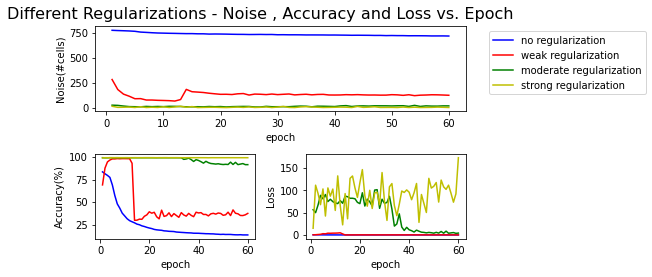

In [163]:
epochs = np.arange(1, args['epochs'] + 1)

fig = plt.figure()

ax1 = plt.subplot(224)
ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss')
ax1.plot(epochs, dev_losses_n1, 'b-', label = 'no regularization')
ax1.plot(epochs, dev_losses_n2, 'r-', label = 'weak regularization')
ax1.plot(epochs, dev_losses_n3, 'g-', label = 'regular regularization')
ax1.plot(epochs, dev_losses_n4, 'y-', label = 'strong regularization')
ax1.tick_params(axis='y')

ax2 = plt.subplot(223)
ax2.set_xlabel('epoch')
ax2.set_ylabel('Accuracy(%)') 
ax2.plot(epochs, dev_accuracy_n1, 'b-', label = 'no regularization')
ax2.plot(epochs, dev_accuracy_n2, 'r-', label = 'weak regularization')
ax2.plot(epochs, dev_accuracy_n3, 'g-', label = 'regular regularization')
ax2.plot(epochs, dev_accuracy_n4, 'y-', label = 'strong regularization')
ax2.tick_params(axis='y')

ax3 = plt.subplot(211)
ax3.set_xlabel('epoch')
ax3.set_ylabel('Noise(#cells)') 
ax3.plot(epochs, dev_noises_n1, 'b-', label = 'no regularization')
ax3.plot(epochs, dev_noises_n2, 'r-', label = 'weak regularization')
ax3.plot(epochs, dev_noises_n3, 'g-', label = 'moderate regularization')
ax3.plot(epochs, dev_noises_n4, 'y-', label = 'strong regularization')
ax3.tick_params(axis='y')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Different Regularizations - Noise , Accuracy and Loss vs. Epoch', fontsize=16)
fig.savefig(FIG_PATH + 'Different Regularizations - Noise , Accuracy and Loss vs Epoch', bbox_inches='tight')
plt.show()

# Appendix C - Perturbed Images Examples

In [151]:
def create_examples(model, data_loader, device, cnn):
    examples = []
    model.eval()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            orig = cnn(data).argmax(dim=1, keepdim=True).cpu() 
            output, _ = model1.generate(data, device)  
            adv = cnn(output).argmax(dim=1, keepdim=True).cpu()
            ex = output.squeeze(dim=1).cpu()
            break

    for i in range(len(orig)):
        examples.append((orig[i], adv[i], ex[i]))
    
    return examples

def show_exmples(examples):
    cnt = 0
    plt.figure(figsize = (8, 10))
    for i in range(min(64, len(examples))):
        cnt += 1
        plt.subplot(8, 8, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        orig,adv,ex = examples[i]
        plt.title("{} -> {}".format(orig.item(), adv.item()))
        plt.imshow(ex, cmap = "gray")
    plt.tight_layout()
    plt.savefig(FIG_PATH + 'Adverserial Examples', bbox_inches='tight')
    plt.show()

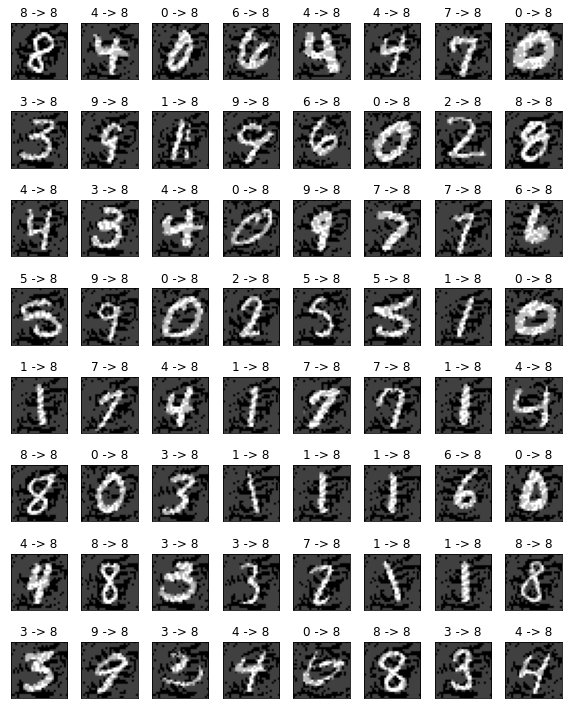

In [154]:
examples = create_examples(model1, test_loader, device, cnn)
show_exmples(examples)

In [161]:
def calc_true_vs_predicted_table(data_loader, cnn, model, device):
    table = np.zeros((10, 10))
    model.eval()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device) 
            output, _ = model.generate(data, device)  
            adv = cnn(output).argmax(dim=1, keepdim=True).cpu()
        
            for i in range(len(data)):
                table[target[i].item(), adv[i].item()] += 1
    table = table.astype('int32')
    return table

def plot_true_vs_predicted(table):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(table, cmap = 'gray')

    # We want to show all ticks...
    ax.set_ylabel("true label", size = 20)
    ax.set_xlabel("predicted label", size = 20)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))

    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, table[i, j],
                       ha="center", va="center", color="red", size=20)

    ax.set_title("True vs. Predicted Label", size = 20)
    fig.tight_layout()
    plt.savefig(FIG_PATH + 'Adverserial Examples Labels', bbox_inches='tight')
    plt.show()

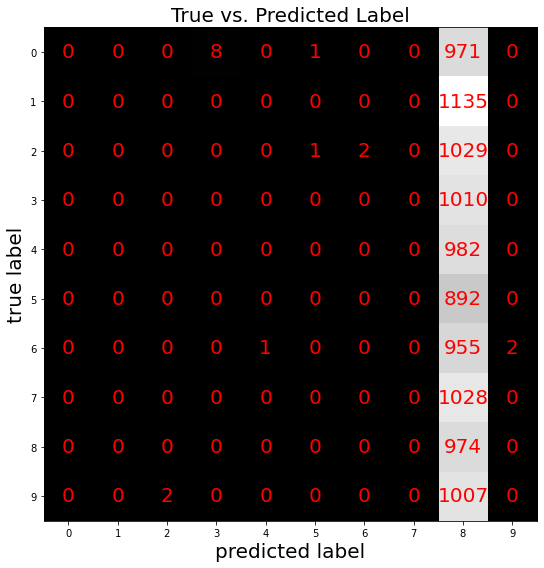

In [160]:
table = calc_true_vs_predicted_table(test_loader, cnn, model1, device)
plot_true_vs_predicted(table)

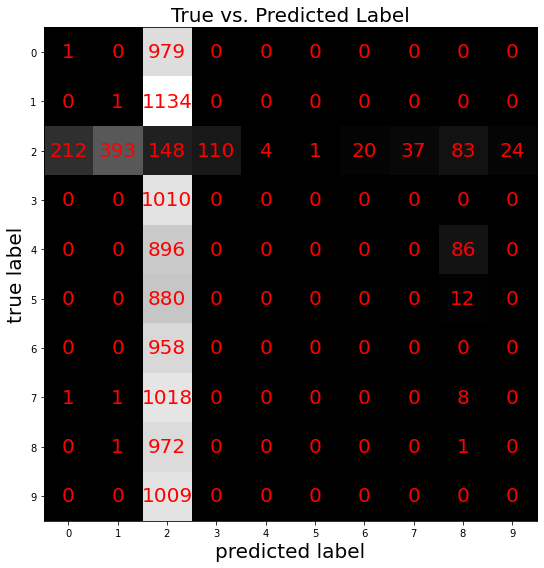

In [162]:
#model2 (whic is PLS_CONV)
table = calc_true_vs_predicted_table(test_loader, cnn, model2, device)
plot_true_vs_predicted(table)